**GROUP 1 : ASSIGNMENT 3 : DiffusionModels**

In [ ]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode
import os
import zipfile
import random
from PIL import Image
# from torch.utils.data import Dataset, DataLoader
# from scipy.linalg import sqrtm
from torchvision import transforms, models
# import pandas as pd
# import json
from torch.optim import lr_scheduler
import torch.nn.functional as F
from sklearn.metrics import f1_score
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset,random_split,TensorDataset


In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Dont forget to use the GPU using .to(device)!
# Use anaconda3/bin/python 3.12.4 base environment while using FIST server

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Loading the dataset in [0,1] range
# animal_images = torch.load("/home/sahapthank/models/training_images.pt")
butterfly_images = torch.load("/home/sahapthank/models/butterfly_training_images.pth")
# butterfly_labels = torch.load("/home/sahapthank/models/butterfly_training_classindices.pth")
# anime_images = torch.load("/home/sahapthank/models/anime_images.pth")
# animal_images_augmented = torch.load("/home/sahapthank/models/animal_images_augmented.pth")
# butterfly_images_augmented = torch.load("/home/sahapthank/models/butterfly_images_augmented.pth")


In [ ]:
# DATA AUGMENTATION FOR BUTTERFLY
horizontal_flip = transforms.RandomHorizontalFlip(p=1)    # Randomly flip the image horizontally
rotation = transforms.RandomRotation(degrees=20)    # Random rotation with expanding size
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Random color adjustments

tensor_shape = (6499,3,128,128)
flipped_images = torch.zeros(tensor_shape)
rotated_images = torch.zeros(tensor_shape)
color_jittered_images = torch.zeros(tensor_shape)

for i in range(6499):
    flipped_images[i] = horizontal_flip(butterfly_images[i])
    rotated_images[i] = rotation(butterfly_images[i])
    color_jittered_images[i]= color_jitter(butterfly_images[i])

butterfly_images_augmented = torch.stack([butterfly_images,flipped_images,rotated_images,color_jittered_images])

In [ ]:
# DATA AUGMENTATION FOR ANIMAL
horizontal_flip = transforms.RandomHorizontalFlip(p=1)    # Randomly flip the image horizontally
rotation = transforms.RandomRotation(degrees=20)    # Random rotation with expanding size
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)  # Random color adjustments

tensor_shape = (90,60,3,128,128)
flipped_images = torch.zeros(tensor_shape)
rotated_images = torch.zeros(tensor_shape)
color_jittered_images = torch.zeros(tensor_shape)

for i in range(90):
    for j in range(60):
        flipped_images[i][j] = horizontal_flip(animal_images[i][j])
        rotated_images[i][j] = rotation(animal_images[i][j])
        color_jittered_images[i][j] = color_jitter(animal_images[i][j])

animal_images_augmented = torch.stack([animal_images,flipped_images,rotated_images,color_jittered_images])

In [ ]:
# ANOTHER WAY OF AUGMENTATION FOR BUTTERFLY [preferred]
horizontal_flip = transforms.RandomHorizontalFlip(p=1)    # Randomly flip the image horizontally
flipped_images = torch.stack([horizontal_flip(img) for img in butterfly_images])
# Define the elastic transform
elastic_transform = transforms.ElasticTransform(
    alpha=50.0,
    sigma=5.0,
    interpolation=InterpolationMode.BILINEAR,
    fill=0
)
# Apply the elastic transform to each image in the batch
deformed_images = torch.stack([elastic_transform(img) for img in butterfly_images])
butterfly_images_augmented_2 = torch.cat((butterfly_images,flipped_images),dim=0)


In [ ]:
# CHANGE THIS CODE BASED ON DATASET
training_images = torch.reshape(butterfly_images_augmented_2,(-1,3,128,128))
# Convert values from [0, 1] to [-1, 1]
training_images = ((2 * training_images) - 1)
print(training_images.size())
first_image = (training_images[0] + 1)/2
first_image = first_image.permute(1, 2, 0)
plt.imshow(first_image)
plt.axis('off')
plt.show()
print(torch.min(training_images))


In [ ]:
# Sample from a Gaussian for inference
def sample_gaussian(mean, covariance_matrix , n_samples):
    # mean should be of size ([d])
    # variance is the covariance matrix of size ([d,d]) must be +ve semidefinite
    z = torch.distributions.MultivariateNormal(mean,covariance_matrix)
    return z.sample([n_samples])
    # returns of size ([n_samples,d])

# Sample from "CURRENT TRAINING IMAGES"
def sample_train(n_samples):
    i_indices = torch.randint(0, training_images.size(0), (n_samples,)).tolist()
    sampled_images = []
    for i in i_indices:
        sampled_images.append(training_images[i])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor

# Sample from Real_images [BUTTERFLY]
def sample_real_butterfly(n_samples):
    i_indices = torch.randint(0, 6499, (n_samples,)).tolist()
    sampled_images = []
    for i in i_indices:
        sampled_images.append(butterfly_images[i])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor

# Sample from Real_images [ANIMAL]
def sample_real_animal(n_samples):
    i_indices = torch.randint(0, 90, (n_samples,)).tolist() # chooses class
    j_indices = torch.randint(0, 60, (n_samples,)).tolist() # chooses image in class
    sampled_images = []
    for i, j in zip(i_indices, j_indices):
        sampled_images.append(animal_images[i, j])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor

# Sample from Real_images [ANIMAL] including augmented
def sample_real_augmented_animal(n_samples):
    i_indices = torch.randint(0, 90, (n_samples,)).tolist() # chooses class
    j_indices = torch.randint(0, 60, (n_samples,)).tolist() # chooses image in class
    k_indices = torch.randint(0, 4, (n_samples,)).tolist() # chooses augmentation type
    sampled_images = []
    for i, j , k in zip(i_indices, j_indices , k_indices):
        sampled_images.append(animal_images_augmented[k, i, j])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor

# Sample from Real_images [BUTTERFLY] including augmented
def sample_real_augmented_butterfly(n_samples):
    i_indices = torch.randint(0, 6499, (n_samples,)).tolist() # chooses image
    k_indices = torch.randint(0, 4, (n_samples,)).tolist() # chooses augmentation type
    sampled_images = []
    for i, k in zip(i_indices, k_indices):
        sampled_images.append(butterfly_images_augmented[k, i])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor

# Sample from Real_images [ANIME]
def sample_real_anime(n_samples):
    i_indices = torch.randint(0, 21551, (n_samples,)).tolist()
    sampled_images = []
    for i in i_indices:
        sampled_images.append(anime_images[i])
    sampled_images_tensor = torch.stack(sampled_images)
    return sampled_images_tensor


**[Q1,2] DDPM : Denoising Diffusion Probabilistic Model**

**U-Net Architecture [Without TimeEmbeddings]**

In [ ]:
# UNet class
class UNet(nn.Module):
    def __init__(self, A):
        super(UNet, self).__init__()
        self.down_blocks = nn.ModuleList()
        self.bottleneck = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.final_conv = nn.Sequential(nn.Conv2d(A[3][0], A[3][1], kernel_size=A[3][2], stride=A[3][3], padding = A[3][4]), nn.Tanh())

        # A[0] contains all info about down_blocks
        # A[0] = [down_block_1,down_block_2,...]
        # down_block_1 = [2,[3,64,3,1,0],nn.ReLU(),2]
        # A[1] contains information about BottleNeck layer
        # A[1] = [2,[512,1024,3,1,0],nn.ReLU()]
        # A[2] contains all information about up_blocks in same way as A[0]
        # A[2] = [up_block_1,up_block_2,...]
        # up_block_1 = [2,[1024,512,3,1,0],nn.ReLU(),[1024,512,2,2,0]]
        # A[3] = [64,3,1,1,0] is the 1x1 final_conv

        # Downsampling path
        for i in range(len(A[0])):
            block = nn.ModuleList()
            num_conv_layers = A[0][i][0]
            conv_specs = A[0][i][1]
            activation = A[0][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.down_blocks.append(block)
            self.down_blocks.append(nn.MaxPool2d(A[0][i][3]))

        # Bottleneck layer
        i_feature = A[1][1][0]
        o_feature = A[1][1][1]
        k = A[1][1][2]
        s = A[1][1][3]
        p = A[1][1][4]
        for _ in range(A[1][0]):
            bottleneck_conv = nn.Conv2d(i_feature, o_feature, k, stride=s, padding=p)
            self.bottleneck.append(nn.Sequential(bottleneck_conv, nn.BatchNorm2d(o_feature), A[1][2]))
            # Update it
            i_feature = o_feature

        # Upsampling path
        for i in range(len(A[2])):
            # Transposed Conv for upsampling instead of max-pooling
            up_A = A[2][i][3]
            up = nn.ConvTranspose2d(up_A[0], up_A[1], kernel_size=up_A[2], stride=up_A[3] , padding=up_A[4])
            self.up_blocks.append(up)
            block = nn.ModuleList()
            num_conv_layers = A[2][i][0]
            conv_specs = A[2][i][1]
            activation = A[2][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.up_blocks.append(block)

    # self.down_blocks is an instance of nn.ModuleList()
    # It stores all the downsampling blocks as individual modules + MaxPooling
    # Each downsampling block is also nn.ModuleList containing a sequence of {ConvLayers + BN + Activation}
    def forward(self, x):
        # To store the outputs for skip connections
        encoder_outputs = []

        # Downsampling path
        for i in range(0, len(self.down_blocks), 2):
            block = self.down_blocks[i]
            # block is nn.ModuleList()
            for layer in block:
                # Each layer is nn.Sequential()
                x = layer(x)
            encoder_outputs.append(x)
            # Perform MaxPooling
            x = self.down_blocks[i+1](x)

        # Bottleneck
        for layer in self.bottleneck:
            x = layer(x)

        # Upsampling path
        for i in range(0, len(self.up_blocks), 2):
            # Upsample the feature map
            up_conv = self.up_blocks[i]
            x = up_conv(x)
            # Retrieve the corresponding feature map from downsampling for skip connection
            skip_connection = encoder_outputs[-(i//2 + 1)]
            # Resize skip connection to match x dimensions (using crop or interpolation)
            skip_connection = F.interpolate(skip_connection, size=x.shape[2:], mode='bilinear', align_corners=False)
            # Concatenate skip connection with upsampled feature map
            x = torch.cat([x, skip_connection], dim=1)
            block = self.up_blocks[i+1]
            for layer in block:
                x = layer(x)

        # Final output
        x = self.final_conv(x)
        return x

    # We will use this to prevent calculating gradients wrt parameters of UNet
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# The original Unet architecture for reference
# They used {2 times 3x3 Conv(p=0,s=1) + Relu + 2x2 MaxPooling(s=2)} in the downsampling
# (2,572,572) becomes (512,32,32) on reaching the BottleNeck Layer
# There they use {2 times 3x3 Conv(p=0,s=1) + Relu + No MaxPooling}
# i/p to upsampling is (1024,28,28)
# In the upsampling procedure max pooling is replaced by {up_con/trans_conc of 2x2 and feature maps are halved here}
# The feature maps from the encoder are concatenated with the upsampled feature maps (skip connections)
# Copy and crop is used to attach since feature maps of encoder have slightly larger spatial size due to bottleneck layer
# Then they use  {2 times 3x3 Conv(p=0,s=1) + Relu} to reduce feature maps progressively
# Final o/p before last operation is (64,388,388)
# Last step is 1x1 Conv to (2,388,388) the o/p segmentation map
# 31M parameters
A_Original = [
    # A[0]: Downsampling blocks
    [
        # Down block 1
        [2, [3, 64, 3, 1, 0], nn.ReLU(), 2],
        # Down block 2
        [2, [64, 128, 3, 1, 0], nn.ReLU(), 2],
        # Down block 3
        [2, [128, 256, 3, 1, 0], nn.ReLU(), 2],
        # Down block 4
        [2, [256, 512, 3, 1, 0], nn.ReLU(), 2]
    ],

    # A[1]: Bottleneck layer
    [2, [512, 1024, 3, 1, 0], nn.ReLU()],

    # A[2]: Upsampling blocks
    [
        # Up block 1
        [2, [1024, 512, 3, 1, 0], nn.ReLU(), [1024, 512, 2, 2, 0]],
        # Up block 2
        [2, [512, 256, 3, 1, 0], nn.ReLU(), [512, 256, 2, 2, 0]],
        # Up block 3
        [2, [256, 128, 3, 1, 0], nn.ReLU(), [256, 128, 2, 2, 0]],
        # Up block 4
        [2, [128, 64, 3, 1, 0], nn.ReLU(), [128, 64, 2, 2, 0]]
    ],

    # A[3]: Final 1x1 convolution
    [64, 2, 1, 1, 0]
]


In [ ]:
# Just checking!
U_check = UNet(A_Original)
# print(model)
a = torch.randn(7, 3, 572, 572)
b = U_check(a)
print(b.shape)
TP1 = sum(p.numel() for p in U_check.parameters())
print(TP1)
# o/p is [7, 2, 388, 388] as expected!
# 31,043,586

**Unet Architecture [with Time Embeddings]**

* Main modification is Time embeddings are added after each Convolutional Block before applying the Pooling operation
* Both MaxPooling and AvgPooling can be tried
* Projection matrices are used to project time embeddings to the appropriate output channel size in each layer. Once projected the same is added to every pixel
* Padding=1 is used instead of zero as in the original Unet paper. This helps to preserve the dimensions inside each block after the Convolutions. Reduction in spatial dimension is only achieved via pooling







In [ ]:
# Sinusoidal embeddings are a technique used to encode position information, commonly used in Transformer architectures
# Sin,Cos help the model to represent position of tokens in a continuous fashion
# Suppose positional embedding is of dimension "d"
# Then PE(t,2i) = sin(t/[10000]^{2i/d}) , PE(t,2i+1) = cos(t/[10000]^{2i/d})
# These embedding gets added into the input of each residual block in the U-net

# 1) The time embedding get added at end of each encoder block before max-pooling
# 2) These additions affect the further encoder block outputs
# 3) In upsampling the time embedding is added after the up_conv2d before convolutions
# 4) Then this further affects the concatenation and further upsampling outputs

# Typically the time embedding is initially is a 1D tensor of shape say (T,d)
# Where T is for max_time_steps and d is embedding dimensions
# Since both spatial and #channels vary in all the encoder outputs as well as upsampling
# What we do is project "d" onto #channels and use expand to (H,W) that is the same embedding in all pixels!

# A very important POINT TO Note
# If we simply modify the contents of x in-place (for example, x += 1 or x.mul_(2)), then the original x_t will also reflect those changes
# as both x and x_t reference the same data.
# However, if we reassign x to a new tensor (e.g., x = layer(x)), we are not modifying the original tensor.
# Instead, we are changing what x points to. The original tensor x_t remains unchanged.

# UNet class for DDPM
class UNet_DDPM(nn.Module):
    def __init__(self, A, T , d , device):
        super(UNet_DDPM, self).__init__()
        self.down_blocks = nn.ModuleList()
        self.bottleneck = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.final_conv = nn.Sequential(nn.Conv2d(A[3][0], A[3][1], kernel_size=A[3][2], stride=A[3][3], padding = A[3][4]), nn.Tanh())
        # self.final_conv = nn.Sequential(nn.Conv2d(A[3][0], A[3][1], kernel_size=A[3][2], stride=A[3][3], padding = A[3][4]))

        # Positional embeddings for all time T each of dim d
        positions = torch.arange(T, dtype=torch.float).unsqueeze(1)  # (T, 1)
        dimensions = torch.arange(d, dtype=torch.float).unsqueeze(0)  # (1, d)
        angle_rates = 1 / (10000 ** (dimensions / d))  # (1, d)
        angles = positions * angle_rates  # (T, d)
        # Apply the sine and cosine functions
        pos_embedding = torch.empty((T, d))
        pos_embedding[:, 0::2] = torch.sin(angles[:, 0::2])  # Apply sine to even indices
        pos_embedding[:, 1::2] = torch.cos(angles[:, 1::2])  # Apply cosine to odd indices
        self.time_embedding = pos_embedding.to(device)

        #Collecting feature map numbers and Setting up the projection maps
        downsampling_features = []
        upsampling_features = []
        for block in A[0]:
            downsampling_features.append(block[1][1])
        for block in A[2]:
            upsampling_features.append(block[1][0]//2)
        # Creating projection layers as nn.ModuleList
        self.downsampling_projections = nn.ModuleList([nn.Linear(d, out_features) for out_features in downsampling_features])
        self.upsampling_projections = nn.ModuleList([nn.Linear(d, out_features) for out_features in upsampling_features])

        # A[0] contains all info about down_blocks
        # A[0] = [down_block_1,down_block_2,...]
        # down_block_1 = [2,[3,64,3,1,0],nn.ReLU(),2]
        # A[1] contains information about BottleNeck layer
        # A[1] = [2,[512,1024,3,1,0],nn.ReLU()]
        # A[2] contains all information about up_blocks in same way as A[0]
        # A[2] = [up_block_1,up_block_2,...]
        # up_block_1 = [2,[1024,512,3,1,0],nn.ReLU(),[1024,512,2,2,0]]
        # A[3] = [64,3,1,1,0] is the 1x1 final_conv

        # Downsampling path
        for i in range(len(A[0])):
            block = nn.ModuleList()
            num_conv_layers = A[0][i][0]
            conv_specs = A[0][i][1]
            activation = A[0][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.down_blocks.append(block)
            self.down_blocks.append(nn.MaxPool2d(A[0][i][3]))

        # Bottleneck layer
        i_feature = A[1][1][0]
        o_feature = A[1][1][1]
        k = A[1][1][2]
        s = A[1][1][3]
        p = A[1][1][4]
        for _ in range(A[1][0]):
            bottleneck_conv = nn.Conv2d(i_feature, o_feature, k, stride=s, padding=p)
            self.bottleneck.append(nn.Sequential(bottleneck_conv, nn.BatchNorm2d(o_feature), A[1][2]))
            # Update it
            i_feature = o_feature

        # Upsampling path
        for i in range(len(A[2])):
            # Transposed Conv for upsampling instead of max-pooling
            up_A = A[2][i][3]
            up = nn.ConvTranspose2d(up_A[0], up_A[1], kernel_size=up_A[2], stride=up_A[3] , padding=up_A[4])
            self.up_blocks.append(up)
            block = nn.ModuleList()
            num_conv_layers = A[2][i][0]
            conv_specs = A[2][i][1]
            activation = A[2][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.up_blocks.append(block)

    # self.down_blocks is an instance of nn.ModuleList()
    # It stores all the downsampling blocks as individual modules + MaxPooling
    # Each downsampling block is also nn.ModuleList containing a sequence of {ConvLayers + BN + Activation}
    def forward(self, x, t):
        # x is of shape (bs,C,H,W)
        # t of shape (bs,) and take care of indices since t in [1,2,..T]
        time_embedding = self.time_embedding[t-1]
        # To store the outputs for skip connections
        encoder_outputs = []

        # Downsampling path
        for i in range(0, len(self.down_blocks), 2):
            block = self.down_blocks[i]
            # block is nn.ModuleList()
            for layer in block:
                # Each layer is nn.Sequential()
                x = layer(x)
            projected_embedding = self.downsampling_projections[i//2](time_embedding).unsqueeze(-1).unsqueeze(-1)
            projected_embedding = projected_embedding.expand_as(x)
            x = x + projected_embedding
            encoder_outputs.append(x)
            # Perform MaxPooling
            x = self.down_blocks[i+1](x)

        # Bottleneck
        for layer in self.bottleneck:
            x = layer(x)

        # Upsampling path
        for i in range(0, len(self.up_blocks), 2):
            # Upsample the feature map
            up_conv = self.up_blocks[i]
            x = up_conv(x)
            # Retrieve the corresponding feature map from downsampling for skip connection
            skip_connection = encoder_outputs[-(i//2 + 1)]
            # Resize skip connection to match x dimensions (using crop or interpolation)
            skip_connection = F.interpolate(skip_connection, size=x.shape[2:], mode='bilinear', align_corners=False)
            # Concatenate skip connection with upsampled feature map after incorporating time_embedding
            projected_embedding = self.upsampling_projections[i//2](time_embedding).unsqueeze(-1).unsqueeze(-1)
            projected_embedding = projected_embedding.expand_as(x)
            x = x + projected_embedding
            x = torch.cat([x, skip_connection], dim=1)
            block = self.up_blocks[i+1]
            for layer in block:
                x = layer(x)

        # Final output
        x = self.final_conv(x)
        return x

    # We will use this to prevent calculating gradients wrt parameters of UNet_DDPM
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Just checking!
U_check = UNet_DDPM(A_Original , 1000, 64 , "cpu")
a = torch.randn(7, 3, 572, 572)
t0 = torch.randint(low=0, high=1001, size=(7,))
b = U_check(a , t0)
print(b.shape)
TP1 = sum(p.numel() for p in U_check.parameters())
print(TP1)
# o/p is [7, 2, 388, 388] as expected!
# 311,68,386


**UNet with More Modifications specific for DDPM**

* Incorporate time embeddings in BottleNeck layer as well
* Add Self-attention maps at 16x16 spatial dimension layers
* Can use ResidualBlocks instead of simple sequential {2,3x3 ConvLayers} in a single block
* Can also use GroupNorm over BatchNorm2d





In [ ]:
class SelfAttention_Image(nn.Module):
    def __init__(self, in_channels):
        super(SelfAttention_Image, self).__init__()
        self.W_Q = nn.Conv2d(in_channels, in_channels, 1)
        self.W_K = nn.Conv2d(in_channels, in_channels, 1)
        self.W_V = nn.Conv2d(in_channels, in_channels, 1)
        self.scale = 1.0 / (in_channels ** 0.5)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch, channels, height, width = x.size()
        q = self.W_Q(x).view(batch, channels, -1)  # Shape: (batch, channels, H*W)
        k = self.W_K(x).view(batch, channels, -1)
        v = self.W_V(x).view(batch, channels, -1)
        attn = torch.bmm(q.transpose(1, 2), k) * self.scale  # (batch, H*W, H*W)
        attn = self.softmax(attn)
        out = torch.bmm(v , attn.transpose(1, 2)).view(batch, channels, height, width)
        return out + x  # Residual connection


In [ ]:
"""U-Net, originally developed for semantic segmentation, is used in DDPMs with some slight modifications
The network accepts two inputs: Image and time step
Time Embeddings: Integrated at every skip connection and the bottleneck layer.
Activation Functions: Swish or Leaky ReLU used instead of standard ReLU.
Normalization: Group Normalization replaces Batch Normalization.
Attention Mechanism: Often included, but not needed if not performing text conditional generation"""

class UNet_DDPM_1(nn.Module):
    def __init__(self, A, T , d , device):
        super(UNet_DDPM_1, self).__init__()
        self.down_blocks = nn.ModuleList()
        self.bottleneck = nn.ModuleList()
        self.up_blocks = nn.ModuleList()
        self.final_conv = nn.Sequential(nn.Conv2d(A[3][0], A[3][1], kernel_size=A[3][2], stride=A[3][3], padding = A[3][4]), nn.Tanh())
        # self.final_conv = nn.Sequential(nn.Conv2d(A[3][0], A[3][1], kernel_size=A[3][2], stride=A[3][3], padding = A[3][4]))

        # Positional embeddings for all time T each of dim d
        positions = torch.arange(T, dtype=torch.float).unsqueeze(1)  # (T, 1)
        dimensions = torch.arange(d, dtype=torch.float).unsqueeze(0)  # (1, d)
        angle_rates = 1 / (10000 ** (dimensions / d))  # (1, d)
        angles = positions * angle_rates  # (T, d)
        # Apply the sine and cosine functions
        pos_embedding = torch.empty((T, d))
        pos_embedding[:, 0::2] = torch.sin(angles[:, 0::2])  # Apply sine to even indices
        pos_embedding[:, 1::2] = torch.cos(angles[:, 1::2])  # Apply cosine to odd indices
        self.time_embedding = pos_embedding.to(device)

        #Collecting feature map numbers and Setting up the projection maps
        downsampling_features = []
        upsampling_features = []
        bottleneck_features = A[1][1][1]
        for block in A[0]:
            downsampling_features.append(block[1][1])
        for block in A[2]:
            upsampling_features.append(block[1][0]//2)

        # Creating projection layers as nn.ModuleList
        self.downsampling_projections = nn.ModuleList([nn.Linear(d, out_features) for out_features in downsampling_features])
        self.upsampling_projections = nn.ModuleList([nn.Linear(d, out_features) for out_features in upsampling_features])
        self.bottleneck_projections = nn.ModuleList([nn.Linear(d, bottleneck_features) for j in range(A[1][0])])

        # Create the self-attention
        self.down_attention = SelfAttention_Image(512)
        self.up_attention = SelfAttention_Image(512)

        # A[0] contains all info about down_blocks
        # A[0] = [down_block_1,down_block_2,...]
        # down_block_1 = [2,[3,64,3,1,0],nn.ReLU(),2]
        # A[1] contains information about BottleNeck layer
        # A[1] = [2,[512,1024,3,1,0],nn.ReLU()]
        # A[2] contains all information about up_blocks in same way as A[0]
        # A[2] = [up_block_1,up_block_2,...]
        # up_block_1 = [2,[1024,512,3,1,0],nn.ReLU(),[1024,512,2,2,0]]
        # A[3] = [64,3,1,1,0] is the 1x1 final_conv

        # Downsampling path
        for i in range(len(A[0])):
            block = nn.ModuleList()
            num_conv_layers = A[0][i][0]
            conv_specs = A[0][i][1]
            activation = A[0][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.down_blocks.append(block)
            # self.down_blocks.append(nn.MaxPool2d(A[0][i][3]))
            self.down_blocks.append(nn.AvgPool2d(A[0][i][3]))

        # Bottleneck layer
        i_feature = A[1][1][0]
        o_feature = A[1][1][1]
        k = A[1][1][2]
        s = A[1][1][3]
        p = A[1][1][4]
        for _ in range(A[1][0]):
            bottleneck_conv = nn.Conv2d(i_feature, o_feature, k, stride=s, padding=p)
            self.bottleneck.append(nn.Sequential(bottleneck_conv, nn.BatchNorm2d(o_feature), A[1][2]))
            # Update it
            i_feature = o_feature

        # Upsampling path
        for i in range(len(A[2])):
            # Transposed Conv for upsampling instead of max-pooling
            up_A = A[2][i][3]
            up = nn.ConvTranspose2d(up_A[0], up_A[1], kernel_size=up_A[2], stride=up_A[3] , padding=up_A[4])
            self.up_blocks.append(up)
            block = nn.ModuleList()
            num_conv_layers = A[2][i][0]
            conv_specs = A[2][i][1]
            activation = A[2][i][2]
            i_feature = conv_specs[0]
            o_feature = conv_specs[1]
            k = conv_specs[2]
            s = conv_specs[3]
            p = conv_specs[4]
            for _ in range(num_conv_layers):
                conv = nn.Conv2d(i_feature, o_feature, kernel_size = k , stride = s, padding = p)
                block.append(nn.Sequential(conv, nn.BatchNorm2d(o_feature), activation))
                # Update #channels for next conv_layer
                i_feature = o_feature
            self.up_blocks.append(block)

    # self.down_blocks is an instance of nn.ModuleList()
    # It stores all the downsampling blocks as individual modules + MaxPooling
    # Each downsampling block is also nn.ModuleList containing a sequence of {ConvLayers + BN + Activation}
    def forward(self, x, t):
        # x is of shape (bs,C,H,W)
        # t of shape (bs,) and take care of indices since t in [1,2,..T]
        time_embedding = self.time_embedding[t-1]
        # To store the outputs for skip connections
        encoder_outputs = []

        # Downsampling path
        for i in range(0, len(self.down_blocks), 2):
            block = self.down_blocks[i]
            # block is nn.ModuleList()
            for layer in block:
                # Each layer is nn.Sequential()
                x = layer(x)
            projected_embedding = self.downsampling_projections[i//2](time_embedding).unsqueeze(-1).unsqueeze(-1)
            projected_embedding = projected_embedding.expand_as(x)
            x = x + projected_embedding
            # Perform attention!
            if (int(x.size(2)) == 16):
                x = self.down_attention(x)
            encoder_outputs.append(x)
            # Perform MaxPooling
            x = self.down_blocks[i+1](x)

        # Bottleneck
        for j,layer in enumerate(self.bottleneck):
            x = layer(x)
            projected_embedding = self.bottleneck_projections[j](time_embedding).unsqueeze(-1).unsqueeze(-1)
            projected_embedding = projected_embedding.expand_as(x)
            x = x + projected_embedding

        # Upsampling path
        for i in range(0, len(self.up_blocks), 2):
            # Upsample the feature map
            up_conv = self.up_blocks[i]
            x = up_conv(x)
            # Retrieve the corresponding feature map from downsampling for skip connection
            skip_connection = encoder_outputs[-(i//2 + 1)]
            # Resize skip connection to match x dimensions (using crop or interpolation)
            skip_connection = F.interpolate(skip_connection, size=x.shape[2:], mode='bilinear', align_corners=False)
            # Concatenate skip connection with upsampled feature map after incorporating time_embedding
            projected_embedding = self.upsampling_projections[i//2](time_embedding).unsqueeze(-1).unsqueeze(-1)
            projected_embedding = projected_embedding.expand_as(x)
            x = x + projected_embedding
            if (int(x.size(2)) == 16):
                x = self.up_attention(x)
            x = torch.cat([x, skip_connection], dim=1)
            block = self.up_blocks[i+1]
            for layer in block:
                x = layer(x)

        # Final output
        x = self.final_conv(x)
        return x

    # We will use this to prevent calculating gradients wrt parameters of UNet_DDPM
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Just checking!
U_check = UNet_DDPM_1(A_Original , 1000, 64 , "cpu")
a = torch.randn(7, 3, 572, 572)
t0 = torch.randint(low=0, high=1001, size=(7,))
b = U_check(a , t0)
print(b.shape)
TP1 = sum(p.numel() for p in U_check.parameters())
print(TP1)
# o/p is [7, 2, 388, 388] as expected!
# 311,68,386


**General Idea of a DDPM**

In [ ]:
# We start with a Markovian Hierarchichal VAE := MHVAE
# A VDM := Variational Diffusion Model has 3 key restrictions:
# 1) latent_dim = data_dim (meaning images here)
# 2) Structure of latent-encoder is not learnt; Predefined as Linear Gaussian [Centered at o/p of previous time-step]
# 3) Gaussian parameters of the latent encoders vary over time in such a way that the distribution of
# the latent at final timestep T, i.e p(x_T) is N(0,I) meaning each pixel is indepndently std Normal

# From now on use the convention xt for latent at timestep [1,2,..T] and x0 for i/p image
# {Mean ; SD} of each Latent Encoder is set before training as HyperParameters [Alpha replace by "a"]
# We typically use the default parameterisation where x_t = root(a_t)*x_{t-1} + root((1-a_t))*e ; where e is N(0,I)
# This form of {a_t} make the Encoder Variance preserving
# {a_t} can also be learnt but generally in practice kept fixed!
# It is a steady noisification of an image input over time
# Only interested in learning the conditionals p_theta(x_{t-1}|x_t)

# Both for image prediction and error prediction UNET is only being used as final o/p has dim as i/p image
# Note THAT FOR DDPM Training images going to be in [-1,1]

class DDPM_Denoiser(nn.Module):
    def __init__(self, T, beta_start, beta_end , A , embedding_dim , device):
        super(DDPM_Denoiser, self).__init__()
        # Define {alpha_t := a_t = 1 - beta_t} and {b_t := a_t "bar" = alphas_cumprod}
        # {alpha_t} decrease for noising and thereby {beta_t} increase
        self.T = T
        # Define a linear beta schedule (common practice is 1e-4 to 0.02)
        # Alphas are supposed to be defined from 1 to T only! So be careful with indices!
        self.betas = torch.linspace(beta_start, beta_end, steps=self.T).to(device)  # (T,)
        self.alphas = (1 - self.betas).to(device)  # (T,)
        self.alphas_cumprod = (torch.cumprod(self.alphas, dim=0)).to(device)  # (T,)

        # Store the sqrt directly for ease of computation
        self.sqrt_alphas = torch.sqrt(self.alphas)
        self.sqrt_betas = torch.sqrt(self.betas)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - self.alphas_cumprod)

        # Store the following for easy inference/training
        # mean_q_t;0  and sigma_squared_q are used [1 to T] but indexed [0,T-1]
        self.mean_q_t = torch.zeros(self.T).to(device)  # (T,)
        self.mean_q_t[0] = 0
        for i in range(1,self.T):
            self.mean_q_t[i] = (1 - self.alphas_cumprod[i-1]) * self.sqrt_alphas[i] / (1 - self.alphas_cumprod[i])
        self.mean_q_0 = torch.zeros(self.T).to(device)  # (T,)
        self.mean_q_0[0] = 1
        for i in range(1,self.T):
            self.mean_q_0[i] = (self.betas[i]) * self.sqrt_alphas_cumprod[i-1] / (1 - self.alphas_cumprod[i])
        self.sigma_squared_q = torch.zeros(self.T).to(device)  # (T,)
        self.sigma_squared_q[0] = 0
        for i in range(1,self.T):
            self.sigma_squared_q[i] = (self.betas[i]) * (1 - self.alphas_cumprod[i-1]) / (1 - self.alphas_cumprod[i])
        self.sigma_q = torch.sqrt(self.sigma_squared_q)
        self.e_q = (self.betas/self.sqrt_one_minus_alphas_cumprod)
        self.unet = UNet_DDPM_1(A , self.T , embedding_dim , device).to(device)

    # Forward pass via the Unet
    def forward(self, x, t):
        # x is of shape (bs, C, H, W)
        # t is of shape (bs,) containing the time steps [int]
        return self.unet(x,t)

    # Helper functions inside the Denoiser Class itself
    def q_sample(self, encoding, t):
        # ENSURE t of shape (bs,) in range[1,...T]
        batch_size = encoding.shape[0]
        mean = self.sqrt_alphas[t-1].view(batch_size, 1, 1, 1) * encoding
        std = self.sqrt_betas[t-1].view(batch_size, 1, 1, 1)
        noise = torch.randn_like(encoding)
        # We are assuming std is same for all dimensions
        next_encoding = mean + (std * noise)
        return (next_encoding)

    def q_sample_from_x0(self, original_image, t):
        # ENSURE t of shape (bs,) in range[1,2,..T]
        batch_size = original_image.shape[0]
        mean = self.sqrt_alphas_cumprod[t-1].view(batch_size, 1, 1, 1) * original_image
        std = self.sqrt_one_minus_alphas_cumprod[t-1].view(batch_size, 1, 1, 1)
        noise = torch.randn_like(original_image)
        # We are assuming std is same for all dimensions
        encoding_t = mean + (std * noise)
        return (encoding_t,noise)

    # We will use this to prevent calculating gradients wrt parameters of DDPM_Denoiser
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Formula for CNN convolutions
# output_size = ({input_size - kernel_size + 2*padding}/stride) + 1
# Formula for Transpose Conv
# output_size = {(input_size - 1) * stride} - (2*padding) + kernel_size}

# Trial-1 [498,035]
# We us padding to preserve sizes properly!
# A_small = [
#     # A[0]: Downsampling blocks
#     [
#         # Down block 1
#         [2, [3, 16, 3, 1, 1], nn.ReLU(), 2], #(128 to 64)
#         # Down block 2
#         [2, [16, 32, 3, 1, 1], nn.ReLU(), 2], #(64 to 32)
#         # Down block 3
#         [2, [32, 64, 3, 1, 1], nn.ReLU(), 2], #(32 to 16)
#     ],

#     # A[1]: Bottleneck layer
#     [2, [64, 128, 3, 1, 1], nn.ReLU()], #(16 to 16)

#     # A[2]: Upsampling blocks
#     [
#         # Up block 1
#         [2, [128, 64, 3, 1, 1], nn.ReLU(), [128, 64, 2, 2, 0]], #(16 to 32)
#         # Up block 2
#         [2, [64, 32, 3, 1, 1], nn.ReLU(), [64, 32, 2, 2, 0]], #(32 to 64)
#         # Up block 3
#         [2, [32, 16, 3, 1, 1], nn.ReLU(), [32, 16, 2, 2, 0]], #(64 to 128)
#     ],

#     # A[3]: Final 1x1 convolution
#     [16, 3, 1, 1, 0]
# ]

# Trial -2 [7,828,451]
# Larger Architecture for the Diffusion Model
# Increased capacity with more filters and additional layers
# A_small = [
#     # A[0]: Downsampling blocks
#     [
#         # Down block 1
#         [2, [3, 32, 3, 1, 1], nn.ReLU(), 2],  #(128 to 64)
#         # Down block 2
#         [2, [32, 64, 3, 1, 1], nn.ReLU(), 2],  #(64 to 32)
#         # Down block 3
#         [2, [64, 128, 3, 1, 1], nn.ReLU(), 2],  #(32 to 16)
#         # Down block 4 (additional layer)
#         [2, [128, 256, 3, 1, 1], nn.ReLU(), 2], #(16 to 8)
#     ],

#     # A[1]: Bottleneck layer
#     [2, [256, 512, 3, 1, 1], nn.ReLU()],  #(8 to 8)

#     # A[2]: Upsampling blocks
#     [
#         # Up block 1
#         [2, [512, 256, 3, 1, 1], nn.ReLU(), [512, 256, 2, 2, 0]], #(8 to 16)
#         # Up block 2
#         [2, [256, 128, 3, 1, 1], nn.ReLU(), [256, 128, 2, 2, 0]], #(16 to 32)
#         # Up block 3
#         [2, [128, 64, 3, 1, 1], nn.ReLU(), [128, 64, 2, 2, 0]], #(32 to 64)
#         # Up block 4 (additional layer)
#         [2, [64, 32, 3, 1, 1], nn.ReLU(), [64, 32, 2, 2, 0]], #(64 to 128)
#     ],

#     # A[3]: Final 1x1 convolution
#     [32, 3, 1, 1, 0]
# ]

# Trial- 3 [31,291,331]
A_small = [
    # A[0]: Downsampling blocks
    [
        # Down block 1
        [2, [3, 64, 3, 1, 1], nn.ReLU(), 2],  #(128 to 64)
        # Down block 2
        [2, [64, 128, 3, 1, 1], nn.ReLU(), 2],  #(64 to 32)
        # Down block 3
        [2, [128, 256, 3, 1, 1], nn.ReLU(), 2],  #(32 to 16)
        # Down block 4 (additional layer)
        [2, [256, 512, 3, 1, 1], nn.ReLU(), 2], #(16 to 8)
    ],

    # A[1]: Bottleneck layer
    [2, [512, 1024, 3, 1, 1], nn.ReLU()],  #(8 to 8)

    # A[2]: Upsampling blocks
    [
        # Up block 1
        [2, [1024, 512, 3, 1, 1], nn.ReLU(), [1024, 512, 2, 2, 0]], #(8 to 16)
        # Up block 2
        [2, [512, 256, 3, 1, 1], nn.ReLU(), [512, 256, 2, 2, 0]], #(16 to 32)
        # Up block 3
        [2, [256, 128, 3, 1, 1], nn.ReLU(), [256, 128, 2, 2, 0]], #(32 to 64)
        # Up block 4 (additional layer)
        [2, [128, 64, 3, 1, 1], nn.ReLU(), [128, 64, 2, 2, 0]], #(64 to 128)
    ],

    # A[3]: Final 1x1 convolution
    [64, 3, 1, 1, 0]
]


In [ ]:
# Rough checking if code so far behaves as expected
DDPM_check = DDPM_Denoiser(1000 , 1e-4 , 0.02 , A_small , 128 , device).to(device)
r1 = torch.randn((7,3,128,128)).to(device)
# The low value is inclusive, and the high value is exclusive
r3 = torch.randint(low=1, high=1001, size=(7,)).to(device)
r2 = DDPM_check(r1,r3)
print(r2.size())
TP1 = sum(p.numel() for p in DDPM_check.parameters())
print(TP1)


**Interpretation-1 [Predicting Original Image from Denoised version]**

**Observations:**
* In the UNet paper they state that it relies on DataAugmentations. This was also observed while training the DDPM where augmentation improved image quality but took more number of epochs
* They also suggest to initialize weights such that each feature map has unit variance which is done by default in pytorch using "Kaiming Initialization" that is specifically for ReLU activations
* It was difficult to make "higher timesteps denoising" good as the #timesteps increases to 1000. But it was relatively better at T = 500







In [ ]:
# log p(x) = ELBO + {Intractable term} where ELBO = A - B - C
# A := Reconstruction Term = E_{q(x1|x0)}[log p_theta(x0|x1)]
# This is analogous to ELBO of VAE can be done using MSE-Likelihood + MonteCarlo
# B := Prior-Matching Term = D_kl(q(xT|x0) || p(xT))
# B has no trainable parameters and equal to zero under our assumptions!
# C := Denoising-Matching Term = sum{t=2 to T}[E_{q(xt|x0)}[D_kl(q(x_{t-1}|xt,x0) || p_theta(x_{t-1}|x_t))]]
# The bulk of the optimisation lies in C [minimize C,maximize A,maximize ELBO]

# The difficulty to optimize C in general case is the reason to use simple Gaussian Transitions to make it analytic!
# Use b_t = a_t "bar"
# q(xt|x0) = N(xt ; root(b_t) ; (1 - b_t)I)
# Using above q(x_{t-1}|xt,x0) = Constant * N(x_{t-1} ; mu_q(xt,x0) ; sigma^2_q(t)I)
# In above formula we have
# 1) mu_q(xt,x0) = [{root(a_t) * (1 - b_{t-1}) * xt} + {root(b_{t-1}) * (1 - a_{t}) * x0}] / [1 - b_t]
# 2) sigma^2_q(t) = (1 - a_t) * (1 - b_{t-1}) / [1 - b_t]
# Mean is function of (xt,x0) and variance is essentially fixed but depends on timestep
# Therefore p_theta(x_{t-1}|x_t) is MODELLED AS A GAUSSIAN WITH SAME COVARINCE
# The only thing going to be parameterised using a NN is mu_theta(xt,t)
# Note That x0 information is technically conveyed via the variable "t of timestep"!

# Under above assumptions the D_kl term of C for each timestep becomes the following:
# D_kl(.,.) = 1/(2*sigma^2_q(t)) * [mu_theta(xt,t) - mu_q(xt,x0)] ^ 2
# Now this can be FURTHER SIMPLIFIED in METHOD 1
# To match both the "mu" knowing the form of mu_q(xt,x0) the coefficient of xt can be fixed for mu_theta
# What we can NOW learn is simply x0 = x_theta(xt,t) assuming mu_theta is "same form" as "mu_q(xt,x0)"
# Now it simplifies to Objective_1 = 1/(2*sigma^2_q(t)) * {b_{t-1} * (1 - a_t)^2/(1 - bt)^2 } * [mu_theta(xt,t) - x0] ^ 2
# The A term also combines to give sum{t=1 to T} * 1/(2*sigma^2_q(t)) * (mu_q_0 ^ 2) * [E_{q(xt|x0)}[x_theta(xt) - x0]^2]
# Therefore, optimizing a VDM boils down to learning a neural network to predict the original ground truth
# image from an arbitrarily noisified version of it with some weighting factor over time-steps

# Furthermore, minimizing the summation involved in C; aross all noise levels
# can be approximated by minimizing the expectation over all timesteps
# Sample a random timestep "t" uniformly from [1 to T]
# Now fixing this t..get many xt by sampling from q(xt|x0) using encoding
# then apply Objective_1 to each and take average to compute inner expectation

# The DDPM Image-Prediction Model
lr_ddpm , m , time_embedding_dim = 1e-4, 128 , 512
T = 1000
b_1 = 1e-4
b_T = 0.02
ddpm = DDPM_Denoiser(T , b_1 , b_T , A_small , time_embedding_dim , device).to(device)
ddpm_loss = []
ddpm_params = list(ddpm.parameters())
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.7, 0.99), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)


In [ ]:
# Manual changing if needed
lr_ddpm , m = 5e-5, 64
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.5, 0.98), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)


In [ ]:
# DDPM Method 1 training algorithm
num_epochs = 10
mini_batch_epochs = 200
epsilon = 1e-15
mse_loss = nn.MSELoss(reduction='none')

# Training loop
for epoch in range(num_epochs):
    for _ in range(mini_batch_epochs):
        ddpm.set_requires_grad(True)
        ddpm_optimizer.zero_grad()

        # Sample m random images from the training dataset
        x0 = sample_train(m).to(device)
        # 1) Sampling a random int timestep from 1 to T for each image
        t = torch.randint(low=1, high=ddpm.T+1, size=(m,)).to(device)  # Shape: (m,)
        # Compute time-dependent weights for each timestep in the batch
        # time_weights = torch.tensor([0.5 * (1.0 / (ddpm.sigma_squared_q[j-1] + epsilon)) * (ddpm.mean_q_0[j-1]) ** 2 for j in t] , device=x0.device)
        time_weights = torch.tensor([1 for j in t] , device=x0.device)
        # 2) Use q_sample_from_x0 to get the perturbed images
        perturbed_images = (ddpm.q_sample_from_x0(x0, t))[0].to(device)  # Shape: (m, C, H, W)
        # 3) Pass the perturbed images and the timesteps to the DDPM
        denoised_images = ddpm(perturbed_images, t)  # Shape: (m, C, H, W)
        # 4) Apply the loss function appropriate for DDPM
        loss = mse_loss(denoised_images, x0).mean(dim=(1, 2, 3)).view(-1, 1)
        time_weights = time_weights.view(x0.shape[0],1)
        weighted_loss = torch.mean(loss * time_weights,dim=0)
        weighted_loss.backward()
        ddpm_optimizer.step()
        ddpm_loss.append(weighted_loss.item())


In [ ]:
# Plot DDPM loss
plt.figure(figsize=(8, 6))
ddpm_steps = range(len(ddpm_loss))
plt.plot(ddpm_steps, ddpm_loss, label='DDPM_loss', color='green')
plt.xlabel('Mini-Batch Epochs')
plt.ylabel('Loss Value')
plt.title('Denoising Matching Term [PredictingImage]')
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Inference
N_timesteps = ddpm.T
N_images = 100

with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I)
    # Currently t = T
    x_t = torch.randn(N_images, 3, 128, 128).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps,0,-1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the denoised output x_theta(xt)
        x_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        # Note that due to indices starting from zero we need to do a "t-1"
        x_t_minus_1 = ((ddpm.mean_q_t[t-1] * x_t) + (ddpm.mean_q_0[t-1] * x_theta_xt) + (ddpm.sigma_q[t-1] * z))
        # Prepare x_t for the next iteration
        # x_t = torch.clamp(x_t_minus_1, -1, 1)
        x_t = x_t_minus_1

    images = (torch.clamp(x_t,-1,1).detach().cpu().numpy())
    # Create a figure for the grid of images
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
    # Loop through the 100 images and display them in the grid
    for i, ax in enumerate(axes.flat):
        img = (images[i].transpose(1, 2, 0) + 1)/2
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Visualize how the IMAGES ARE GENERATED
N_timesteps = ddpm.T
N_images = 8
timesteps_to_plot = torch.arange(N_timesteps, 0, -100).tolist()

# Initialize a list to store the images at the specified timesteps
images_at_timesteps = [[] for _ in range(N_images)]
with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I)
    x_t = torch.randn(N_images, 3, 128, 128).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps, 0, -1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the denoised output x_theta(xt)
        x_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        x_t_minus_1 = ((ddpm.mean_q_t[t-1] * x_t) +
                        (ddpm.mean_q_0[t-1] * x_theta_xt) +
                        (ddpm.sigma_q[t-1] * z))
        # Store images at the specified timesteps
        if t in timesteps_to_plot:
            idx = timesteps_to_plot.index(t)
            for i in range(N_images):
                images_at_timesteps[i].append(x_t[i].clone())  # Store a copy of the image
        # Prepare x_t for the next iteration
        x_t = x_t_minus_1

# Create a figure for the grid of images
fig, axes = plt.subplots(nrows=N_images, ncols=len(timesteps_to_plot)+1, figsize=(15, 15))
# Loop through the stored images and display them in the grid
for i in range(N_images):
    # Plot the final image (after all timesteps)
    final_image = (torch.clamp(x_t[i], -1, 1).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
    axes[i, -1].imshow(final_image)
    axes[i, -1].axis('off')
    axes[i, -1].set_title('Final Image')
    for j in range(len(timesteps_to_plot)):
        img = (torch.clamp(images_at_timesteps[i][j], -1, 1).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
# Set titles for each column to represent the timesteps
for j, t in enumerate(timesteps_to_plot):
    axes[0, j].set_title(f'Timestep {t}')
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the DENOISING ON THE TRAINING IMAGES
N_timesteps = ddpm.T
s = 8
old_images = torch.empty(s,3,128,128)
new_images = torch.empty(s,9,3,128, 128)

with torch.no_grad():
    for i in range(s):
        # Sample a single training image #bs = 10
        x0 = sample_train(1)
        old_images[i] = x0[0]
        x0 = x0.repeat(9, 1, 1, 1).to(device)
        # 1) Sampling a int timestep from 100 to 1000 for each image
        t = torch.linspace(100, N_timesteps, steps=9).long().to(device)
        # 2) Use q_sample_from_x0 to get the perturbed images
        perturbed_images = (ddpm.q_sample_from_x0(x0, t))[0].to(device)
        # 3) Pass the perturbed images and the timesteps to the DDPM
        denoised_images = ddpm(perturbed_images, t)
        new_images[i] = denoised_images.detach().cpu()

# Create a figure for the s x 10 grid
fig, axes = plt.subplots(nrows=s, ncols=10, figsize=(15, s * 2))
for i in range(s):
    # Plot the i-th old image
    old_img = (old_images[i].cpu().numpy().transpose(1, 2, 0) + 1) / 2  # Normalize [-1,1] to [0,1]
    axes[i, 0].imshow(old_img)
    axes[i, 0].axis('off')
    # Plot the 10 new images in new_images[i]
    for j in range(9):
        new_img = (new_images[i, j].cpu().numpy().transpose(1, 2, 0) + 1) / 2  # Normalize [-1,1] to [0,1]
        axes[i, j + 1].imshow(new_img)
        axes[i, j + 1].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# DONT FORGET TO SAVE THE WEIGHTS!
torch.save(ddpm,"/home/sahapthank/models/1e_60.pth")

**Interpretation-2 [Predicting the Noise]**

In [ ]:
# We can use the reparametrisation trick to get the most common implementation
# Using the q(xt|x0) transitions , express x0 in terms of xt to get
# mu_q(xt,x0) = {1/root(a_t) * x_t} - {(1-a_t)/root[(1-b_t)*a_t] * e0} where e0 is N(0,I)
# Therefore simply set the NN to predict e_theta(xt,t) as proxy for e0
# Now Objective_2 = 1/(2*sigma^2_q(t)) * {(1 - a_t)^2 * b_t-1/(1 - bt) } * [e_theta(xt,t) - e0] ^ 2

# The DDPM Noise-Prediction Model
lr_ddpm , m , time_embedding_dim = 1e-4, 64 , 512
T = 500
b_1 = 1e-4
b_T = 0.02
ddpm = DDPM_Denoiser(T , b_1 , b_T , A_small , time_embedding_dim , device).to(device)
# ddpm = torch.load("/home/sahapthank/models/2a_100.pth")
ddpm_loss = []
ddpm_params = list(ddpm.parameters())
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.7, 0.99), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)


In [ ]:
# Manual changing if needed
lr_ddpm , m = 2e-4, 64
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.7, 0.99), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)


In [ ]:
# DDPM Method 2 training algorithm
num_epochs = 30
mini_batch_epochs = 200
epsilon = 1e-15
mse_loss = nn.MSELoss(reduction='none')

# The true noise is the one that got added to x_t while getting it from x0
# Training loop
for epoch in range(num_epochs):
    for _ in range(mini_batch_epochs):
        ddpm.set_requires_grad(True)
        ddpm_optimizer.zero_grad()

        # Sample m random images from the training dataset
        x0 = sample_train(m).to(device)
        # 1) Sampling a random int timestep from 1 to T for each image
        t = torch.randint(low=1, high=ddpm.T+1, size=(m,)).to(device)  # Shape: (m,)
        # Compute time-dependent weights for each timestep in the batch
        # time_weights = torch.tensor([0.5 * (1.0 / (ddpm.sigma_squared_q[j-1] + epsilon)) * (ddpm.mean_q_0[j-1]) ** 2 for j in t] , device=x0.device)
        time_weights = torch.tensor([1 for j in t] , device=x0.device)
        # 2) Use q_sample_from_x0 to get the perturbed images
        S = ddpm.q_sample_from_x0(x0, t)
        perturbed_images = (S[0]).to(device)  # Shape: (m, C, H, W)
        true_noise = (S[1]).to(device)
        # 3) Pass the perturbed images and the timesteps to the DDPM
        predicted_noise = ddpm(perturbed_images, t)  # Shape: (m, C, H, W)
        # 4) Apply the loss function appropriate for DDPM
        loss = mse_loss(predicted_noise, true_noise).mean(dim=(1, 2, 3)).view(-1, 1)
        time_weights = time_weights.view(x0.shape[0],1)
        weighted_loss = torch.mean(loss * time_weights,dim=0)*3*128*128
        weighted_loss.backward()
        ddpm_optimizer.step()
        ddpm_loss.append(weighted_loss.item())


In [ ]:
# Plot DDPM loss
plt.figure(figsize=(8, 6))
ddpm_steps = range(len(ddpm_loss))
plt.plot(ddpm_steps, ddpm_loss, label='DDPM_loss', color='green')
plt.xlabel('Mini-Batch Epochs')
plt.ylabel('Loss Value')
plt.title('Denoising Matching Term [PredictingErrors]')
plt.legend()
# Show the plot
plt.tight_layout()
plt.show()


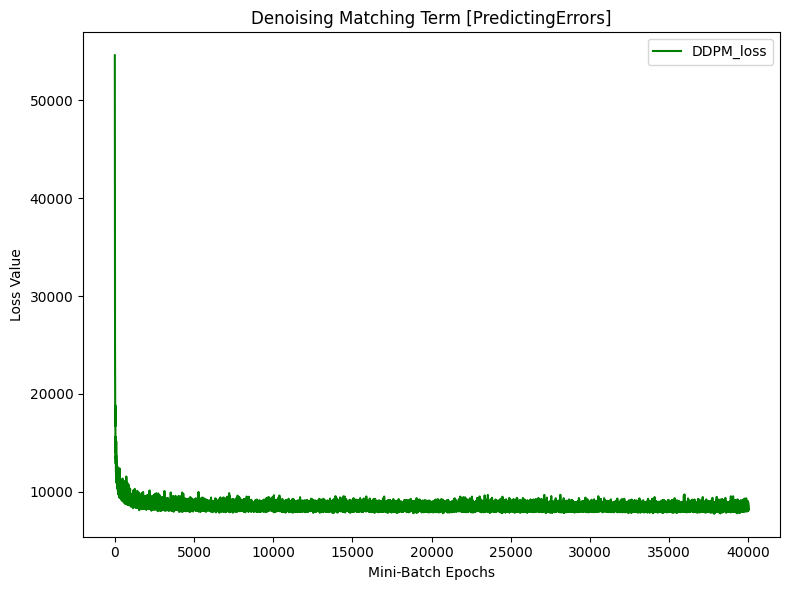

In [ ]:
# Inference
N_timesteps = ddpm.T
N_images = 100
with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I) ; Currently t = T
    x_t = torch.randn(N_images, 3, 128, 128).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps,0,-1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the predicted_noise : e_theta_(xt)
        e_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        # Note that due to indices starting from zero we need to do a "t-1"
        x_t_minus_1 = (((1/ddpm.sqrt_alphas[t-1]) * ((x_t) - (ddpm.e_q[t-1] * e_theta_xt))) + (ddpm.sigma_q[t-1] * z))
        # Prepare x_t for the next iteration
        # x_t = torch.clamp(x_t_minus_1, -1, 1)
        x_t = x_t_minus_1

    images = (torch.clamp(x_t,-1,1).detach().cpu().numpy())
    # Create a figure for the grid of images
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
    # Loop through the 100 images and display them in the grid
    for i, ax in enumerate(axes.flat):
        img = (images[i].transpose(1, 2, 0) + 1)/2
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualize how the IMAGES ARE GENERATED
N_timesteps = ddpm.T
N_images = 8
timesteps_to_plot = torch.arange(N_timesteps, 0, -50).tolist()

# Initialize a list to store the images at the specified timesteps
images_at_timesteps = [[] for _ in range(N_images)]
with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I)
    x_t = torch.randn(N_images, 3, 128, 128).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps, 0, -1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the denoised output x_theta(xt)
        e_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        x_t_minus_1 = (((1/ddpm.sqrt_alphas[t-1]) * ((x_t) - (ddpm.e_q[t-1] * e_theta_xt))) + (ddpm.sigma_q[t-1] * z))
        # Store images at the specified timesteps
        if t in timesteps_to_plot:
            idx = timesteps_to_plot.index(t)
            for i in range(N_images):
                images_at_timesteps[i].append(x_t[i].clone())  # Store a copy of the image
        # Prepare x_t for the next iteration
        x_t = x_t_minus_1

# Create a figure for the grid of images
fig, axes = plt.subplots(nrows=N_images, ncols=len(timesteps_to_plot)+1, figsize=(15, 15))
# Loop through the stored images and display them in the grid
for i in range(N_images):
    # Plot the final image (after all timesteps)
    final_image = (torch.clamp(x_t[i], -1, 1).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
    axes[i, -1].imshow(final_image)
    axes[i, -1].axis('off')
    axes[i, -1].set_title('Final Image')
    for j in range(len(timesteps_to_plot)):
        img = (torch.clamp(images_at_timesteps[i][j], -1, 1).detach().cpu().numpy().transpose(1, 2, 0) + 1) / 2
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
# Set titles for each column to represent the timesteps
for j, t in enumerate(timesteps_to_plot):
    axes[0, j].set_title(f'Timestep {t}')
plt.tight_layout()
plt.show()

In [ ]:
# DONT FORGET TO SAVE THE WEIGHTS!
torch.save(ddpm,"/home/sahapthank/models/2b_500.pth")

**[Q4] Stable Diffusion on VQVAE LatentSpace**

In [ ]:
# VQ-VAE is the SoTa lets see if we can do it properly!
# Learning useful representations without supervision remains a key challenge in ML
# (VQ-VAE) differs from VAEs in two key ways:
# 1) encoder network outputs discrete, rather than continuous, codes; and the prior
# 2) is learnt rather than static.
# Using the VQ method allows the
# model to circumvent issues of “posterior collapse” — where the latents are ignored
# when they are paired with a powerful autoregressive decoder — typically observed in the VAE framework.

# For speech discrete encodings k are 1D and each z_q corresponds to e_q in R^d
# For images (d1,d2) 2D encoding where each (vector along pixel) gets mapped to an embedding vector
# There exist K embedding vectors!
# Basically a CNN is used to convert to z_e(x) = (D,d1,d2) and each {z_e(x)}i,j as a D-dim vectors
# We use nearest neighbours and map it to e_i in R^D!
# We now get z_q(x) = (D,d1,d2) which using a Transpose_CNN we get final image

# Note that there is no real gradient defined for discretisation using nearest neighbour
# however we approximate the gradient similar to the straight-through estimator
# and just copy gradients from decoder input z_q(x) to encoder output z_e(x)
# Since the output representation of the encoder and the input to the decoder share the same D dimensional space,
# the gradients contain useful information for how the encoder has to change its output

class VQ_VAE_Encoder_0(nn.Module):
    def __init__(self, architecture):
        # Has only Convolutions, architecture = [cnn_architecture]
        # cnn_architecture = [conv_params, cnn_batchnorm, cnn_activation_fn]
        # conv_params = [[in_channels, output_channels, kernel_size, stride, padding], ...]
        # cnn_batchnorm = [False, True, ...]
        # cnn_activation = [nn.ReLU(), nn.LeakyReLU(), ...]
        super(VQ_VAE_Encoder_0, self).__init__()
        assert len(architecture[0]) == len(architecture[1]) == len(architecture[2])
        self.conv_params = architecture[0]
        self.cnn_batchnorm = architecture[1]
        self.cnn_activation = architecture[2]

        layers_0 = []
        for j,i in enumerate(self.conv_params):
            (layers_0).append(nn.Conv2d(in_channels=i[0],out_channels=i[1],kernel_size=i[2],stride=i[3],padding=i[4]))
            if (self.cnn_batchnorm)[j]:
                (layers_0).append(nn.BatchNorm2d(i[1]))
            (layers_0).append(self.cnn_activation[j])
        # Stack convolutional layers in a Sequential block
        self.cnn = nn.Sequential(*(layers_0))

    def forward(self, x):
        z_e = self.cnn(x)
        return z_e
    # We will use this to prevent calculating gradients wrt parameters of Encoder
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad

class VQ_VAE_Decoder_0(nn.Module):
    def __init__(self, architecture):
        # The architecture is almost same as DCGAN using transpose_convolutions only
        super(VQ_VAE_Decoder_0, self).__init__()
        assert len(architecture[0]) == len(architecture[1]) == len(architecture[2])
        self.transpose_conv_params = architecture[0]
        self.use_batchnorm = architecture[1]
        self.activation_fn = architecture[2]

        layers = []
        # Starting with input latent vector of 2D image!
        for j, i in enumerate(self.transpose_conv_params):
            layers.append(nn.ConvTranspose2d(in_channels=i[0], out_channels=i[1], kernel_size=i[2], stride=i[3], padding=i[4]))
            if self.use_batchnorm[j]:
                layers.append(nn.BatchNorm2d(i[1]))
            layers.append(self.activation_fn[j])
        self.model = nn.Sequential(*layers)

    # Sampling images from Decoder
    def forward(self, x):
        return self.model(x)
    # We will use this to prevent calculating gradients wrt parameters of Decoder
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Since we assume a uniform prior for z, the KL term that usually appears in the ELBO is constant
# w.r.t. the encoder parameters and can thus be ignored for training
# Note that in VAE KL is only used for encoder training!
# VQVAE has 3 loss terms for the reconstruction
# A = logp(x|z_q(x)) := reconstruction {Encoder and Decoder}
# B = l2 ((sg(z_e(x)),e)) := VQ Objective {Embedding Vectors only}
# C =  beta * l2 ((z_e(x),sg(e))) := CommitmentLoss {Encoder only}

# When we use N = k1*k2 dicrete latents (In paper they use (32,32) for ImageNet)
# The loss terms are averaged for each latent (1/N factor)
# One term for each latent arises in {B,C}
# Whilst training the VQ-VAE, the prior is kept constant and uniform.
# Each region of the image (represented by a latent code) has an equal probability
# of being encoded by any of the embedding vectors from the codebook.

class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_loss_beta):
        super(VectorQuantizer, self).__init__()
        # Codebook containing K embedding vectors
        # Each vector is of dim D
        # D would be the final #output channels in CNN
        # Underscore is used for inplace operation
        # Initialize with unform weights from [-1/K,1/K]
        self.K = num_embeddings
        self.D = embedding_dim
        self.embedding = nn.Embedding(self.K, self.D) #(K,D)
        self.embedding.weight.data.uniform_(-1/self.K, 1/self.K)
        self.beta = commitment_loss_beta

    def forward(self, inputs):
        # convert inputs z_e(x) from (bs,c,h,w) to (bs,h,w,c)
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        # Flatten input to (bs*h*w,c=D)
        flat_input = inputs.view(-1, self.D)
        # Calculate distances of {each pixel_vector with each embedding vector}
        # Final shape is (bs*h*w = N,K)
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True)
                    + (torch.sum((self.embedding.weight)**2, dim=1))
                    - (2 * torch.matmul(flat_input, self.embedding.weight.t())))

        # Encoding
        # Using one-hot encodings allows gradients to flow correctly during backpropagation.
        # If we directly assign embeddings based on indices
        # the computation graph might not accurately reflect the necessary operations for gradient calculation
        # especially when dealing with operations like straight-through estimators
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1) #(N,1)
        encodings = torch.zeros(encoding_indices.shape[0], self.K, device=inputs.device)
        # Keep shape same but put ones in the appropriate positions and 0-elsewhere
        encodings.scatter_(1,encoding_indices,1) #(N,K)
        # Quantize to (N,D) and unflatten to (bs,h,w,c)
        quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
        # Calculate the Loss associated
        # Averaging over {batch and EmbeddingVectors is done by default}
        # MSE btw {z_e(x),sg(e)}
        commitment_loss = F.mse_loss(quantized.detach(),inputs)
        # MSE btw {sg(z_e(x)),e}
        vq_objective = F.mse_loss(quantized,inputs.detach())
        loss_B_C = (vq_objective) + (self.beta * commitment_loss)
        # Trick for straight-through estimation
        quantized = inputs + (quantized - inputs).detach()
        # convert quantized back to (bs,c,h,w) and return (Loss,z_q(x)),B_loss,C_loss)
        return (loss_B_C, quantized.permute(0, 3, 1, 2).contiguous(),commitment_loss.detach(),vq_objective.detach())

    # We will use this to prevent calculating gradients wrt parameters of VQ
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Use the class definitions of VQVAE before loading
E = torch.load("models/vqvae/E_2b_700.pth").to(device)
D = torch.load("models/vqvae/D_2b_700.pth").to(device)
vq = torch.load("models/vqvae/vq_2b_700.pth").to(device)
E.set_requires_grad(False)
D.set_requires_grad(False)
vq.set_requires_grad(False)


In [ ]:
# Get all the latent vectors
# Note that VQVAE Encoder was trained using images in [0,1] space
all_latent_vectors = torch.zeros(6499*2,64,16,16)
batch_size = 64
for i in range(0, 6499*2, batch_size):
    with torch.no_grad():
        x = butterfly_images_augmented_2[i:min(i+batch_size,6499*2)].to(device)
        z_e = E(x)
        z_q = vq(z_e)[1]
        # Calculate the end index for slicing
        end_index = min(i + batch_size, 6499*2)
        # Insert the batch of latents into the correct slice of T
        all_latent_vectors[i:end_index] = z_q
all_latent_vectors = all_latent_vectors.view(-1,64,16,16)
print(all_latent_vectors.shape)


In [ ]:
# Trial- 3 [31,291,331]
A_small = [
    # A[0]: Downsampling blocks
    [
        [3, [64, 128, 3, 1, 1], nn.ReLU(), 2],  #(16 to 8)
        [2, [128, 256, 3, 1, 1], nn.ReLU(), 2],  #(8 to 4)
    ],

    # A[1]: Bottleneck layer
    [3, [256, 512, 3, 1, 1], nn.ReLU()],  #(4 to 4)

    # A[2]: Upsampling blocks
    [
        [2, [512,256, 3, 1, 1], nn.ReLU(), [512,256, 2, 2, 0]], #(4 to 8)
        [3, [256,128, 3, 1, 1], nn.ReLU(), [256,128, 2, 2, 0]], #(8 to 16)
    ],

    # A[3]: Final 1x1 convolution
    [128, 64, 1, 1, 0]
]

In [ ]:
# We can use the reparametrisation trick to get the most common implementation
# Using the q(xt|x0) transitions , express x0 in terms of xt to get
# mu_q(xt,x0) = {1/root(a_t) * x_t} - {(1-a_t)/root[(1-b_t)*a_t] * e0} where e0 is N(0,I)
# Therefore simply set the NN to predict e_theta(xt,t) as proxy for e0
# Now Objective_2 = 1/(2*sigma^2_q(t)) * {(1 - a_t)^2 * b_t-1/(1 - bt) } * [e_theta(xt,t) - e0] ^ 2

# The DDPM Noise-Prediction Model
lr_ddpm , m , time_embedding_dim = 1e-4, 64 , 512
T = 500
b_1 = 1e-4
b_T = 0.02
ddpm = DDPM_Denoiser(T , b_1 , b_T , A_small , time_embedding_dim , device).to(device)
# ddpm = torch.load("/home/sahapthank/models/2a_100.pth")
ddpm_loss = []
ddpm_params = list(ddpm.parameters())
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.7, 0.99), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)


In [ ]:
# Manual changing if needed
lr_ddpm , m = 5e-5, 64
ddpm_optimizer = optim.Adam(ddpm_params, lr=lr_ddpm, betas=(0.7, 0.99), eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.RMSprop(ddpm_params, lr=lr_ddpm, alpha=0.99, eps=1e-8, weight_decay=0)
# ddpm_optimizer = optim.SGD(ddpm_params, lr=lr_ddpm, momentum=0.9, weight_decay=0)

In [ ]:
training_images = all_latent_vectors
# VQVAE was trained using [0,1] images as i/p and o/p
# Encoded vectors actually fit in [-1,1]
# So UNET ddpm has to be final layer nn.Tanh()
# This is a change from previous training

# DDPM Method 2 training algorithm
num_epochs = 20
mini_batch_epochs = 200
epsilon = 1e-15
mse_loss = nn.MSELoss(reduction='none')

# The true noise is the one that got added to x_t while getting it from x0
# Training loop
for epoch in range(num_epochs):
    for _ in range(mini_batch_epochs):
        ddpm.set_requires_grad(True)
        ddpm_optimizer.zero_grad()

        # Sample m random images from the training dataset
        x0 = sample_train(m).to(device)
        # 1) Sampling a random int timestep from 1 to T for each image
        t = torch.randint(low=1, high=ddpm.T+1, size=(m,)).to(device)  # Shape: (m,)
        # Compute time-dependent weights for each timestep in the batch
        # time_weights = torch.tensor([0.5 * (1.0 / (ddpm.sigma_squared_q[j-1] + epsilon)) * (ddpm.mean_q_0[j-1]) ** 2 for j in t] , device=x0.device)
        time_weights = torch.tensor([1 for j in t] , device=x0.device)
        # 2) Use q_sample_from_x0 to get the perturbed images
        S = ddpm.q_sample_from_x0(x0, t)
        perturbed_images = (S[0]).to(device)  # Shape: (m, C, H, W)
        true_noise = (S[1]).to(device)
        # 3) Pass the perturbed images and the timesteps to the DDPM
        predicted_noise = ddpm(perturbed_images, t)  # Shape: (m, C, H, W)
        # 4) Apply the loss function appropriate for DDPM
        loss = mse_loss(predicted_noise, true_noise).mean(dim=(1, 2, 3)).view(-1, 1)
        time_weights = time_weights.view(x0.shape[0],1)
        weighted_loss = torch.mean(loss * time_weights,dim=0)*3*128*128
        weighted_loss.backward()
        ddpm_optimizer.step()
        ddpm_loss.append(weighted_loss.item())


In [ ]:
# Inference
N_timesteps = ddpm.T
N_images = 100
with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I) ; Currently t = T
    x_t = torch.randn(N_images, 64, 16, 16).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps,0,-1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the predicted_noise : e_theta_(xt)
        e_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        # Note that due to indices starting from zero we need to do a "t-1"
        x_t_minus_1 = (((1/ddpm.sqrt_alphas[t-1]) * ((x_t) - (ddpm.e_q[t-1] * e_theta_xt))) + (ddpm.sigma_q[t-1] * z))
        # Prepare x_t for the next iteration
        # x_t = torch.clamp(x_t_minus_1, -1, 1)
        x_t = x_t_minus_1

    x_t = D(x_t)
    images = (torch.clamp(x_t,0,1).detach().cpu().numpy())
    # Create a figure for the grid of images
    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(15, 15))
    # Loop through the 100 images and display them in the grid
    for i, ax in enumerate(axes.flat):
        img = (images[i].transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


In [ ]:
# Visualize how the IMAGES ARE GENERATED
N_timesteps = ddpm.T
N_images = 8
timesteps_to_plot = torch.arange(N_timesteps, 0, -50).tolist()

# Initialize a list to store the images at the specified timesteps
images_at_timesteps = [[] for _ in range(N_images)]
with torch.no_grad():
    # Step 1: Initialize x_T with white noise from N(0, I)
    x_t = torch.randn(N_images, 64, 16, 16).to(device)
    # Step 2: Iterate from {t = T to 1} to obtain x0
    for t in range(N_timesteps, 0, -1):
        # Create a tensor for the current timestep
        t_tensor = torch.full((N_images,), t, dtype=torch.int64).to(device)
        # Step 3: Get the denoised output x_theta(xt)
        e_theta_xt = ddpm(x_t, t_tensor)
        # Generate noise z from N(0, I)
        z = torch.randn_like(x_t)
        # Step 4: Update x_t based on the INFERENCE FORMULA
        x_t_minus_1 = (((1/ddpm.sqrt_alphas[t-1]) * ((x_t) - (ddpm.e_q[t-1] * e_theta_xt))) + (ddpm.sigma_q[t-1] * z))
        # Store images at the specified timesteps
        if t in timesteps_to_plot:
            y_t = D(x_t)
            idx = timesteps_to_plot.index(t)
            for i in range(N_images):
                images_at_timesteps[i].append(y_t[i].clone())  # Store a copy of the image
        # Prepare x_t for the next iteration
        x_t = x_t_minus_1

# Create a figure for the grid of images
x_t = D(x_t)
fig, axes = plt.subplots(nrows=N_images, ncols=len(timesteps_to_plot)+1, figsize=(15, 15))
# Loop through the stored images and display them in the grid
for i in range(N_images):
    # Plot the final image (after all timesteps)
    final_image = (torch.clamp(x_t[i], 0, 1).detach().cpu().numpy().transpose(1, 2, 0))
    axes[i, -1].imshow(final_image)
    axes[i, -1].axis('off')
    axes[i, -1].set_title('Final Image')
    for j in range(len(timesteps_to_plot)):
        img = (torch.clamp(images_at_timesteps[i][j], 0, 1).detach().cpu().numpy().transpose(1, 2, 0))
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
# Set titles for each column to represent the timesteps
for j, t in enumerate(timesteps_to_plot):
    axes[0, j].set_title(f'Timestep {t}')
plt.tight_layout()
plt.show()

**[Q10] Knowledge Distillation on ResNet50**


* Animal Datset [train in [0,1] range] used for training ResNet50 is used to train a smaller CNN/MLP using knowledge distillation
* The loss function has 2 components with higher priority to "distillation loss" where small model tries to match the "logits/softmax" of the ResNet [temp of softmax is varied to find suitable soft targets] . MSE loss is used here.
* The other component , "supervised-loss" is given low weightage to predict the correct class labels for training dataset. These act as "hard targets". The same high temperature is
used when training the distilled model, but after it has been trained it uses a temperature of 1 for inference.
* Typically, the small model cannot exactly match the soft targets and erring in the direction of the
correct answer turns out to be helpful.





In [ ]:
# animal images is [0,1] (90,60,3,128,128)
# labels is (5400,3,128,128) [0,0,..60 times,1,1,,,60 times,...89,...60 times]
from torch.utils.data import DataLoader, TensorDataset, random_split

data = animal_images.reshape(-1,3,128,128)
data = F.interpolate(data, size=(224, 224), mode='bilinear', align_corners=False)
# Set up labels and transformation pipeline
Labels = torch.tensor([i for i in range(90) for _ in range(60)])
# Normalize for ResNet-50
transform = transforms.Compose([transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
data = torch.stack([transform(image) for image in data])
dataset = TensorDataset(data, Labels)

# For Reproducability :)
torch.manual_seed(42)
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [ ]:
# Distilled Model / Student Model
class DistilledModel(nn.Module):
    def __init__(self, architecture):
        # architecture = [cnn_architecture, nn_architecute]
        # nn_architecture = [nn_layers, nn_batch_norm , nn_activation]
        # cnn_architecture = [conv_params, cnn_batchnorm, cnn_activation_fn]
        # conv_params = [[in_channels, output_channels, kernel_size, stride, padding], ...]
        # nn/cnn_batchnorm = [False, True, ...]
        # nn/cnn_activation = [nn.ReLU(), nn.LeakyReLU(), ...]
        super(DistilledModel, self).__init__()
        assert len(architecture[0][0]) == len(architecture[0][1]) == len(architecture[0][2])
        assert len(architecture[1][0]) == len(architecture[1][1]) == len(architecture[1][2])
        self.conv_params = architecture[0][0]
        self.cnn_batchnorm = architecture[0][1]
        self.cnn_activation = architecture[0][2]
        self.nn_layers = architecture[1][0]
        self.nn_batchnorm = architecture[1][1]
        self.nn_activation = architecture[1][2]
        layers_0 = []
        for j,i in enumerate(self.conv_params):
            (layers_0).append(nn.Conv2d(in_channels=i[0],out_channels=i[1],kernel_size=i[2],stride=i[3],padding=i[4]))
            if (self.cnn_batchnorm)[j]:
                (layers_0).append(nn.BatchNorm2d(i[1]))
            (layers_0).append(self.cnn_activation[j])
        layers_1 = []
        for i in range(len(self.nn_layers)):
            in_dim, out_dim = self.nn_layers[i]
            (layers_1).append(nn.Linear(in_dim, out_dim))
            if self.nn_batchnorm[i]:
                (layers_1).append(nn.BatchNorm1d(out_dim))
            (layers_1).append(self.nn_activation[i])
        # Stack convolutional layers in a Sequential block
        # Create 1 FFNN
        self.cnn = nn.Sequential(*(layers_0))
        self.nn = nn.Sequential(*(layers_1))

    def forward(self, x):
        features = self.cnn(x)
        features = torch.flatten(features, start_dim=1)
        logits = self.nn(features)
        return logits
    # We will use this to prevent calculating gradients wrt parameters of DistilledModel
    def set_requires_grad(self, requires_grad):
        for param in self.parameters():
            param.requires_grad = requires_grad


In [ ]:
# Architecture for the distilled model
# Formula for CNN convolutions
# output_size = ({input_size - kernel_size + 2*padding}/stride) + 1

# TRIAL 1 [1M parameters]
conv_params_3 = [[3,16,4,2,1],[16,16,4,2,1],[16,32,4,2,1],[32,32,4,2,1]]
# CONVERT from [3,128,128] = 49,152 to [32,8,8] = 2048
cnn_batchnorm_3 = [True for _ in range(4)]
cnn_activation_3 = [nn.LeakyReLU(0.2, inplace=False) for _ in range(4)]
classifier_cnn = [conv_params_3, cnn_batchnorm_3, cnn_activation_3]
nn_layers_3 = [[2048,512],[512,128],[128,90]]
nn_batchnorm_3 = [True for _ in range(2)] + [False]
nn_activation_3 = [nn.ReLU() for _ in range(2)] + [nn.Identity()]
# We will use soft-max while doing the CE loss
classifier_nn = [nn_layers_3, nn_batchnorm_3, nn_activation_3]
classifier_arch = [classifier_cnn , classifier_nn]


In [ ]:
Classifier_check = DistilledModel(classifier_arch)
r1 = torch.randn((7,3,128,128))
r2 = Classifier_check(r1)
print(r2.size())
TP1 = sum(p.numel() for p in Classifier_check.parameters())
print(TP1)


In [ ]:
# Initialize model, loss function, and optimizer
lr_d =1e-4
D = DistilledModel(classifier_arch).to(device)
# temp for softmax is a hyperparameter
distillation_temp = 25
R = torch.load("/home/sahapthank/models/resnet50_1.pth").to(device)
for param in R.parameters():
    param.requires_grad = False
Distillation_Loss = []
Supervised_Loss = []
Total_Loss = []
D_params = list(D.parameters())
D_optimizer = optim.Adam(D_params, lr=lr_d, betas=(0.8, 0.98), eps=1e-8, weight_decay=0)


In [ ]:
# Manual adjusting
lr_d = 1e-5
D_optimizer = optim.Adam(D_params, lr=lr_d, betas=(0.8, 0.98), eps=1e-8, weight_decay=0)

In [ ]:
# Training the distilled Model [on same train split of ResNet50]
# CNN training algorithm
num_epochs = 30
criterion = nn.CrossEntropyLoss()
# Training loop
for epoch in range(num_epochs):
    for inputs,labels in train_loader:
        # Move data to the same device as the model
        inputs, labels = inputs.to(device), labels.to(device)
        x1 = inputs
        D.set_requires_grad(True)
        D_optimizer.zero_grad()
        y1 = R(x1)
        scaled_logits_1 = (y1 / distillation_temp)
        x2 = F.interpolate(inputs, size=(128, 128), mode='bilinear', align_corners=False)
        y2 = D(x2)
        scaled_logits_2 = (y2 / distillation_temp)
        # For distillation loss same [distillation_temp used for both]
        # For KL-Loss log is taken for the student_model
        p_prob = F.softmax(scaled_logits_1,dim=1)
        q_log_prob = F.log_softmax(scaled_logits_2,dim=1)
        loss_D = torch.sum((-p_prob) * (q_log_prob),dim=1).mean()
        # For supervised Loss [temp is kept 1 only!]
        loss_S = criterion(y2,labels)
        weight = 1e-4
        loss = (loss_D * (distillation_temp ** 2)) + (weight * loss_S)
        loss.backward()
        D_optimizer.step()
        D_optimizer.zero_grad()

    Distillation_Loss.append(loss_D.item())
    Supervised_Loss.append(loss_S.item())
    Total_Loss.append((loss_D + loss_S).item())


In [ ]:
epochs = range(len(Distillation_Loss))  # Use indices as x-axis values
# Create a figure with three subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
# Plot Distillation Loss in the first subplot
ax1.plot(epochs, Distillation_Loss, label='Distillation Loss', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('Loss')
ax1.set_title('Distillation Loss')
ax1.legend()
# Plot Supervised Loss in the second subplot
ax2.plot(epochs, Supervised_Loss, label='Supervised Loss', color='green')
ax2.set_xlabel('Index')
ax2.set_ylabel('Loss')
ax2.set_title('Supervised Loss')
ax2.legend()
# Plot Total Loss in the third subplot
ax3.plot(epochs, Total_Loss, label='Total Loss', color='red')
ax3.set_xlabel('Index')
ax3.set_ylabel('Loss')
ax3.set_title('Total Loss')
ax3.legend()
# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
# Determine the final classification accuracy on TRAINING SET
Correct = 0
D.set_requires_grad(False)
# We iterate through in batches
# Due to BN layers bs must be > 1
with torch.no_grad():
    for inputs, labels in train_loader:
        labels = labels.to(device)
        x2 = F.interpolate(inputs, size=(128, 128), mode='bilinear', align_corners=False).to(device)
        y = D(x2)
        # Get predicted classes
        predictions = torch.argmax(y,dim=1)
        # Check how many predictions match the ground truth labels
        Correct += (predictions == labels).sum().item()
# Final accuracy calculation
accuracy = Correct * 100 / len(train_dataset)
print("Final Accuracy of CNN on TRAIN:", accuracy)

In [ ]:
# Determine the final classification accuracy on TESTING SET
Correct = 0
D.set_requires_grad(False)
# We iterate through in batches
# Due to BN layers bs must be > 1
with torch.no_grad():
    for inputs, labels in test_loader:
        labels = labels.to(device)
        x2 = F.interpolate(inputs, size=(128, 128), mode='bilinear', align_corners=False).to(device)
        y = D(x2)
        # Get predicted classes
        predictions = torch.argmax(y,dim=1)
        # Check how many predictions match the ground truth labels
        Correct += (predictions == labels).sum().item()
# Final accuracy calculation
accuracy = Correct * 100 / len(test_dataset)
print("Final Accuracy of CNN on TEST:", accuracy)

In [ ]:
torch.save(D,"/models/KD.pth")

**Results of Distillation [1M small model , temp = 25]**
* Accuracy of Teacher ResNet50 Model on TestSet: 41%
* Accuracy of Distilled Model on TestSet without SupervisedLoss: 28.93% [Train:96.22%]
* Accuracy of Distilled Model on TestSet with SupervisedLoss: 29.79% [Train:97.38%]




